In [1]:
from pyspark.sql import SparkSession

In [2]:
#i strated a session and tested it

spark = SparkSession.builder \
    .appName("PhishTounsi_Emails").config("spark.task.maxFailures", "8") \
    .getOrCreate()


print(spark.version)

3.5.3


In [3]:
emails_df = spark.read.csv("Emailsfile.csv", header=True, inferSchema=True)

emails_df.show(5)

+--------+--------------------+
|Category|             Message|
+--------+--------------------+
|     ham|Go until jurong p...|
|     ham|Ok lar... Joking ...|
|    spam|Free entry in 2 a...|
|     ham|U dun say so earl...|
|     ham|Nah I don't think...|
+--------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import when

emails_df = emails_df.withColumn("label", when(emails_df["Category"] == "spam", 1).otherwise(0))

emails_df.show(20)


+--------+--------------------+-----+
|Category|             Message|label|
+--------+--------------------+-----+
|     ham|Go until jurong p...|    0|
|     ham|Ok lar... Joking ...|    0|
|    spam|Free entry in 2 a...|    1|
|     ham|U dun say so earl...|    0|
|     ham|Nah I don't think...|    0|
|    spam|FreeMsg Hey there...|    1|
|     ham|Even my brother i...|    0|
|     ham|As per your reque...|    0|
|    spam|WINNER!! As a val...|    1|
|    spam|Had your mobile 1...|    1|
|     ham|I'm gonna be home...|    0|
|    spam|SIX chances to wi...|    1|
|    spam|URGENT! You have ...|    1|
|     ham|I've been searchi...|    0|
|     ham|I HAVE A DATE ON ...|    0|
|    spam|XXXMobileMovieClu...|    1|
|     ham|Oh k...i'm watchi...|    0|
|     ham|Eh u remember how...|    0|
|     ham|Fine if thats th...|    0|
|    spam|England v Macedon...|    1|
+--------+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import length

emails_df = emails_df.withColumn("email_length", length(emails_df["Message"]))

emails_df.show(20)

+--------+--------------------+-----+------------+
|Category|             Message|label|email_length|
+--------+--------------------+-----+------------+
|     ham|Go until jurong p...|    0|         111|
|     ham|Ok lar... Joking ...|    0|          29|
|    spam|Free entry in 2 a...|    1|         155|
|     ham|U dun say so earl...|    0|          49|
|     ham|Nah I don't think...|    0|          61|
|    spam|FreeMsg Hey there...|    1|         147|
|     ham|Even my brother i...|    0|          77|
|     ham|As per your reque...|    0|         160|
|    spam|WINNER!! As a val...|    1|         157|
|    spam|Had your mobile 1...|    1|         154|
|     ham|I'm gonna be home...|    0|         109|
|    spam|SIX chances to wi...|    1|         136|
|    spam|URGENT! You have ...|    1|         155|
|     ham|I've been searchi...|    0|         196|
|     ham|I HAVE A DATE ON ...|    0|          35|
|    spam|XXXMobileMovieClu...|    1|         149|
|     ham|Oh k...i'm watchi...|

In [ ]:
from pyspark.sql.functions import col, size, split
from pyspark.sql.functions import col, regexp_replace, length

url_regex = r"(http[s]?://\S+|www\.\S+)"

emails_df = emails_df.withColumn("special_char_count", 
    length(col("Message")) - length(regexp_replace(col("Message"), r"[^a-zA-Z0-9\s]", ""))
)

emails_df = emails_df.withColumn("digit_count", 
    length(col("Message")) - length(regexp_replace(col("Message"), r"\d", ""))
)

emails_df = emails_df.withColumn(
    "url_count", 
    size(split(col("Message"), url_regex)) - 1
)


In [7]:
#data cleaning 
emails_df = emails_df.dropna(subset=["Message", "label"])
emails_df = emails_df.dropDuplicates()
emails_df.show(20)

+--------+--------------------+-----+------------+------------------+-----------+---------+
|Category|             Message|label|email_length|special_char_count|digit_count|url_count|
+--------+--------------------+-----+------------+------------------+-----------+---------+
|    spam|Double mins and t...|    1|         149|                 4|         16|        0|
|     ham|They just talking...|    0|          51|                 2|          0|        0|
|     ham|Did he say how fa...|    0|         166|                 3|          2|        0|
|     ham|You flippin your ...|    0|          26|                 1|          0|        0|
|     ham|Eat jap done oso ...|    0|          60|                 7|          2|        0|
|     ham|Where at were hun...|    0|          24|                 0|          0|        0|
|     ham|I couldn't say no...|    0|         150|                 1|          0|        0|
|     ham|Its a site to sim...|    0|          95|                 2|          0

In [ ]:
from pyspark.sql.functions import lower, col

emails_df = emails_df.withColumn("Message", lower(col("Message")))
emails_df.show(20)

+--------+--------------------+-----+------------+------------------+-----------+---------+
|Category|             Message|label|email_length|special_char_count|digit_count|url_count|
+--------+--------------------+-----+------------+------------------+-----------+---------+
|    spam|double mins and t...|    1|         149|                 4|         16|        0|
|     ham|they just talking...|    0|          51|                 2|          0|        0|
|     ham|did he say how fa...|    0|         166|                 3|          2|        0|
|     ham|you flippin your ...|    0|          26|                 1|          0|        0|
|     ham|eat jap done oso ...|    0|          60|                 7|          2|        0|
|     ham|where at were hun...|    0|          24|                 0|          0|        0|
|     ham|i couldn't say no...|    0|         150|                 1|          0|        0|
|     ham|its a site to sim...|    0|          95|                 2|          0

In [ ]:
from pyspark.sql.functions import regexp_replace

emails_df = emails_df.withColumn("Message", regexp_replace(col("Message"), r'[^a-zA-Z\s]', ''))
emails_df.show(20)

+--------+--------------------+-----+------------+------------------+-----------+---------+
|Category|             Message|label|email_length|special_char_count|digit_count|url_count|
+--------+--------------------+-----+------------+------------------+-----------+---------+
|    spam|double mins and t...|    1|         149|                 4|         16|        0|
|     ham|they just talking...|    0|          51|                 2|          0|        0|
|     ham|did he say how fa...|    0|         166|                 3|          2|        0|
|     ham|you flippin your ...|    0|          26|                 1|          0|        0|
|     ham|eat jap done oso ...|    0|          60|                 7|          2|        0|
|     ham|where at were hun...|    0|          24|                 0|          0|        0|
|     ham|i couldnt say no ...|    0|         150|                 1|          0|        0|
|     ham|its a site to sim...|    0|          95|                 2|          0

In [10]:
#tokenize text to words and remove stop words
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

tokenizer = Tokenizer(inputCol="Message", outputCol="words")
emails_df = tokenizer.transform(emails_df)


remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
emails_df = remover.transform(emails_df)

emails_df.show(20)


+--------+--------------------+-----+------------+------------------+-----------+---------+--------------------+--------------------+
|Category|             Message|label|email_length|special_char_count|digit_count|url_count|               words|      filtered_words|
+--------+--------------------+-----+------------+------------------+-----------+---------+--------------------+--------------------+
|    spam|double mins and t...|    1|         149|                 4|         16|        0|[double, mins, an...|[double, mins, tx...|
|     ham|they just talking...|    0|          51|                 2|          0|        0|[they, just, talk...|[talking, thats, ...|
|     ham|did he say how fa...|    0|         166|                 3|          2|        0|[did, he, say, ho...|[say, fantastic, ...|
|     ham|you flippin your ...|    0|          26|                 1|          0|        0|[you, flippin, yo...|[flippin, shit, yet]|
|     ham|eat jap done oso ...|    0|          60|            

In [ ]:
from pyspark.sql.functions import col, size, array_intersect, lit

common_phishing_words = ["free", "win", "urgent", "money", "offer", "click", "prize"]

# Compute the count of common phishing words in 'filtered_words'
emails_df = emails_df.withColumn(
    "common_phishing_words_count",
    size(array_intersect(col("filtered_words"), lit(common_phishing_words)))
)

emails_df.show(20)


+--------+--------------------+-----+------------+------------------+-----------+---------+--------------------+--------------------+---------------------------+
|Category|             Message|label|email_length|special_char_count|digit_count|url_count|               words|      filtered_words|common_phishing_words_count|
+--------+--------------------+-----+------------+------------------+-----------+---------+--------------------+--------------------+---------------------------+
|    spam|double mins and t...|    1|         149|                 4|         16|        0|[double, mins, an...|[double, mins, tx...|                          1|
|     ham|they just talking...|    0|          51|                 2|          0|        0|[they, just, talk...|[talking, thats, ...|                          0|
|     ham|did he say how fa...|    0|         166|                 3|          2|        0|[did, he, say, ho...|[say, fantastic, ...|                          0|
|     ham|you flippin your .

In [12]:
from pyspark.sql.functions import size

emails_df = emails_df.withColumn("word_count", size(col("filtered_words")))
emails_df.show(20)

+--------+--------------------+-----+------------+------------------+-----------+---------+--------------------+--------------------+---------------------------+----------+
|Category|             Message|label|email_length|special_char_count|digit_count|url_count|               words|      filtered_words|common_phishing_words_count|word_count|
+--------+--------------------+-----+------------+------------------+-----------+---------+--------------------+--------------------+---------------------------+----------+
|    spam|double mins and t...|    1|         149|                 4|         16|        0|[double, mins, an...|[double, mins, tx...|                          1|        17|
|     ham|they just talking...|    0|          51|                 2|          0|        0|[they, just, talk...|[talking, thats, ...|                          0|         4|
|     ham|did he say how fa...|    0|         166|                 3|          2|        0|[did, he, say, ho...|[say, fantastic, ...|  

In [ ]:
train_ratio = 0.8
emails_train_df, emails_test_df = emails_df.randomSplit([train_ratio, 1 - train_ratio], seed=42)

train_counts = emails_train_df.groupBy("label").count()
test_counts = emails_test_df.groupBy("label").count()

train_counts.show()
test_counts.show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  502|
|    0| 3660|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    1|  139|
|    0|  858|
+-----+-----+



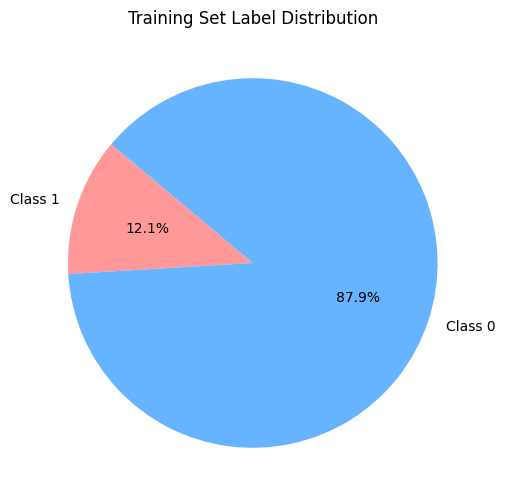

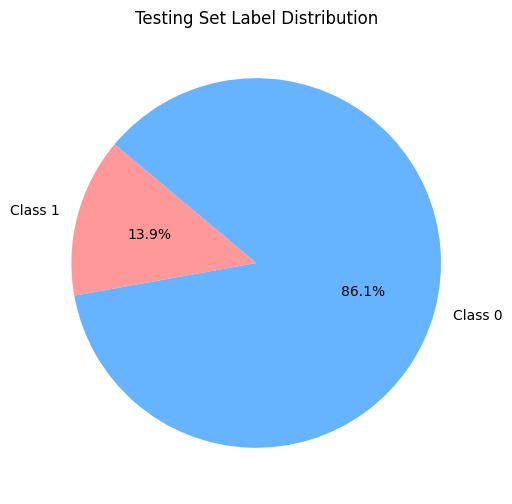

In [ ]:
import matplotlib.pyplot as plt

# Convert the results into dictionaries for easier visualization
train_counts_dict = {row["label"]: row["count"] for row in train_counts.collect()}
test_counts_dict = {row["label"]: row["count"] for row in test_counts.collect()}

# Prepare data for the pie chart
def plot_pie_chart(data_dict, title):
    labels = [f"Class {label}" for label in data_dict.keys()]
    sizes = data_dict.values()

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=["#ff9999", "#66b3ff"])
    plt.title(title)
    plt.show()

plot_pie_chart(train_counts_dict, "Training Set Label Distribution")
plot_pie_chart(test_counts_dict, "Testing Set Label Distribution")

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["email_length", "special_char_count", "digit_count", "url_count", 
                   "common_phishing_words_count", "word_count"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

emails_train_df = assembler.transform(emails_train_df)
emails_test_df = assembler.transform(emails_test_df)

In [ ]:
from pyspark.sql.functions import col, when

total_count = emails_df.count()
count_class_0 = emails_df.filter(col("label") == 0).count()
count_class_1 = emails_df.filter(col("label") == 1).count()

# Calculate class weights
class_weights = {
    0: total_count / count_class_0,
    1: total_count / count_class_1
}

# Add class_weights column to the DataFrame
emails_df = emails_df.withColumn(
    "class_weights",
    when(col("label") == 1, class_weights[1]).otherwise(class_weights[0])
)


In [17]:
from pyspark.ml.classification import LogisticRegression

# Define Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Train the model
lr_model = lr.fit(emails_train_df)




In [18]:
# Make predictions
predictions = lr_model.transform(emails_test_df)

In [19]:
predictions.select("Message", "label", "prediction", "probability").show(900)

+--------------------+-----+----------+--------------------+
|             Message|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|                    |    0|       0.0|[0.99695216774979...|
|        am on my way|    0|       0.0|[0.99325716854862...|
| and half years i...|    0|       0.0|[0.98618412229229...|
| bot notes oredi ...|    0|       0.0|[0.99779390457756...|
| comin to fetch u...|    0|       0.0|[0.99618890991647...|
| give me some tim...|    0|       0.0|[0.99281781269383...|
| im  on the snowb...|    0|       0.0|[0.99265436327183...|
|         min later k|    0|       0.0|[0.98368563349434...|
| predict wat time...|    0|       0.0|[0.99623252513452...|
|  ready then call me|    0|       0.0|[0.99562912822567...|
|     sad puppy noise|    0|       0.0|[0.99586489495141...|
| still attending ...|    0|       0.0|[0.99471326049216...|
| tacos   rajas bu...|    0|       0.0|[0.98355869112119...|
| thats not v roma...|  

In [ ]:
predictions.filter(predictions.label != predictions.prediction).select("Message", "label", "prediction", "probability").show(100)


+--------------------+-----+----------+--------------------+
|             Message|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|for me the love s...|    0|       1.0|[0.01812128854558...|
|you lifted my hop...|    0|       1.0|[0.05774354803767...|
|as one of our reg...|    1|       0.0|[0.79359226145776...|
|bought one ringto...|    1|       0.0|[0.97327948337491...|
|check out choose ...|    1|       0.0|[0.99142995690678...|
|do you ever notic...|    1|       0.0|[0.97377010471217...|
|hello we need som...|    1|       0.0|[0.98717948842015...|
|hi babe its chloe...|    1|       0.0|[0.92463468287938...|
|in the simpsons m...|    1|       0.0|[0.93265382719522...|
|latest news polic...|    1|       0.0|[0.99228999654548...|
|new tones this we...|    1|       0.0|[0.98036077531098...|
|orange brings you...|    1|       0.0|[0.85047305821488...|
|sms ac jsco energ...|    1|       0.0|[0.98540105532142...|
|tbspersolvo been ...|  

In [ ]:
correct_predictions = predictions.filter(predictions.label == predictions.prediction).count()
total_predictions = predictions.count()
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


Correct Predictions: 975 (97.79%)
  Correct Label 0: 856
  Correct Label 1: 119
Incorrect Predictions: 22 (2.21%)
  Incorrect Label 0: 2
  Incorrect Label 1: 20


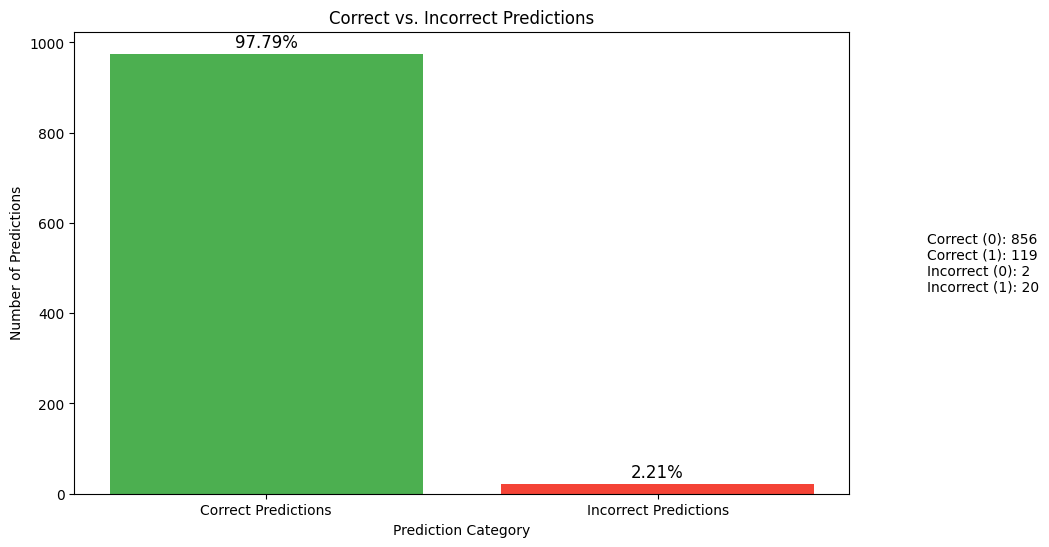

In [22]:
import matplotlib.pyplot as plt

# Calculate counts for correct and incorrect predictions
correct_predictions = predictions.filter(predictions.label == predictions.prediction)
incorrect_predictions = predictions.filter(predictions.label != predictions.prediction)

# Count the total number of predictions
total_predictions = predictions.count()

# Calculate overall counts
correct_count = correct_predictions.count()
incorrect_count = incorrect_predictions.count()

# Calculate percentages
correct_percentage = (correct_count / total_predictions) * 100
incorrect_percentage = (incorrect_count / total_predictions) * 100

# Count correct and incorrect predictions by label
correct_label_0 = correct_predictions.filter(correct_predictions.label == 0).count()
correct_label_1 = correct_predictions.filter(correct_predictions.label == 1).count()
incorrect_label_0 = incorrect_predictions.filter(incorrect_predictions.label == 0).count()
incorrect_label_1 = incorrect_predictions.filter(incorrect_predictions.label == 1).count()

# Print details
print(f"Correct Predictions: {correct_count} ({correct_percentage:.2f}%)")
print(f"  Correct Label 0: {correct_label_0}")
print(f"  Correct Label 1: {correct_label_1}")
print(f"Incorrect Predictions: {incorrect_count} ({incorrect_percentage:.2f}%)")
print(f"  Incorrect Label 0: {incorrect_label_0}")
print(f"  Incorrect Label 1: {incorrect_label_1}")

# Prepare data for bar chart
categories = ['Correct Predictions', 'Incorrect Predictions']
counts = [correct_count, incorrect_count]
percentages = [correct_percentage, incorrect_percentage]

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['#4CAF50', '#F44336'])

# Annotate bars with percentages
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() +5, f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Correct vs. Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.xlabel('Prediction Category')

# Add detailed breakdown as text annotation
details = (f"Correct (0): {correct_label_0}\n"
           f"Correct (1): {correct_label_1}\n"
           f"Incorrect (0): {incorrect_label_0}\n"
           f"Incorrect (1): {incorrect_label_1}")
plt.gca().text(1.1, 0.5, details, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

plt.show()
